In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from geopy.distance import geodesic
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Corrects footpaths in the LoS table
## Needs PT LoS table and footpaths

In [2]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_los')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')

The only kind of all-walk connections between centroids should be direct connections without intermediate stops at PT nodes because these are always connected to access/egress links which have non-footpath properties.

Thus, footpaths already computed in prep2 will be parametrised with census based mean distances.

In [4]:
# Load census data: Zensus 2011 - Einwohnerzahl je Hektar
# Copyright: © Statistisches Bundesamt, Wiesbaden 2015
# (im Auftrag der Herausgebergemeinschaft)
# Vervielfältigung und Verbreitung, auch auszugsweise, mit Quellenangabe gestattet
if os.path.isfile(input_path + 'Zensus_2011.geojson'):
    pop = gpd.read_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')
else:
    print('No file with geometries found')
    import shapely.speedups
    pop = pd.read_csv(input_path + 'Zensus_2011.csv', sep=';')
    # Restrict to entries that hold information
    pop = pop.loc[pop['Einwohner']!=-1]
    pop = gpd.GeoDataFrame(pop[['Einwohner']],
                          geometry=gpd.points_from_xy(pop['x_mp_100m'], pop['y_mp_100m']))
    pop.crs = 3035
    pop.to_crs(sm.epsg, inplace=True)
    pop['FID'] = np.nan
    z = stepmodel.read_zip(model_path + 'de_zones.zip')
    shapely.speedups.enable
    for _, zone in tqdm(z.zones.iterrows(), total=z.zones.shape[0]):
        pop.loc[pop['geometry'].within(zone['geometry']), 'FID'] = zone['FID']
    pop.to_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')

In [5]:
pop.sample()

,Einwohner,NUTS_ID,FID,geometry
1651944,9,DED21,DED21,POINT (13.73385 51.11175)


In [6]:
# Drop walking links that use access-egress links
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type']!='walk']

In [7]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,time,route_type,price,accessibility
index,,,,,,,,,,,,,,
113930,DE24A,DE25A,[rail_long],"[r_l_3695, r_l_3696, r_l_3697, r_l_3698, r_l_8...",2,233751,4829,0,6180,3600,14609,rail_long,34.287562,0.0


In [8]:
# Get zone-connecting footpaths
foot = ae.footpaths.loc[(ae.footpaths['a'].apply(lambda s: len(s.split('_'))<=2)) &
                        (ae.footpaths['b'].apply(lambda s: len(s.split('_'))<=2))]
print(len(foot))
foot.sample()

438


,a,b,length,time,geometry
index,,,,,
foot_9976,DE27A,DE148,25783,5459,"LINESTRING (9.78004 47.82502, 9.85621 47.59888)"


In [9]:
try:
    speed = foot['speed'].mean() # in km/h
except KeyError:
    speed = 17
foot = foot[['a', 'b']].copy()

In [10]:
# Build all columns of LoS table
foot['index'] = foot.index
foot['path'] = [(a,i,b) for a,i,b in zip(foot['a'], foot.index, foot['b'])]
foot.drop('index', axis=1, inplace=True)
foot = foot.rename(columns={'a': 'origin', 'b': 'destination'})
foot['link_path'] = [[] for _ in range(len(foot))]
for col in ['ntransfers', 'access_time', 'footpath_time',
            'in_vehicle_time', 'waiting_time',
            'boarding_time', 'time', 'length', 'price']:
    if col in sm.pt_los.columns:
        foot[col] = 0
foot['accessibility'] = 1
foot['route_types'] = [('walk',) for _ in range(len(foot))]
foot['route_type'] = 'walk'

In [11]:
foot.drop_duplicates(subset=['origin', 'destination'], inplace=True)
foot.reset_index(drop=True, inplace=True)

In [12]:
foot.sample()

,origin,destination,path,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,length,price,accessibility,route_types,route_type
190,DEA33,DEA37,"(DEA33, foot_9896, DEA37)",[],0,0,0,0,0,0,0,0,1,"(walk,)",walk


In [13]:
# Calculate mean population-weighted distances
# from the origin centroid to all points in the destination zone
for ind, row in tqdm(foot.iterrows(), total=len(foot.index)):
    o = ae.centroids.loc[row['origin'], 'geometry']
    zone = pop.loc[pop['NUTS_ID']==row['destination']]
    weighted_dist = [geodesic(o.coords, p['geometry'].coords).m
                     * p['Einwohner'] for _, p in zone.iterrows()]
    foot.loc[ind, 'length'] = sum(weighted_dist) / zone['Einwohner'].sum()

100%|████████████████████████████████████████████████████████████████████████████████| 438/438 [25:59<00:00,  3.56s/it]


<AxesSubplot:>

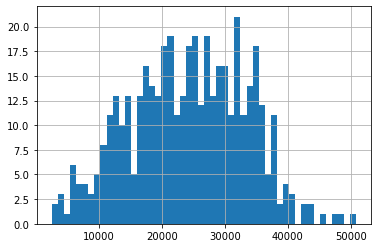

In [14]:
foot['length'].hist(bins=50)

<AxesSubplot:>

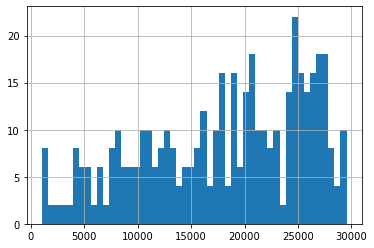

In [15]:
# Compare to quickly approximated distances
ae.footpaths.loc[(ae.footpaths['a'].apply(lambda s: len(s.split('_'))<=2)) &
                 (ae.footpaths['b'].apply(lambda s: len(s.split('_'))<=2)),
                 'length'].hist(bins=50)

In [16]:
# Replace NaN
foot.loc[foot['length'].isna(), 'length'] = foot.loc[foot['length'].notna(), 'length'].mean()

In [17]:
# Generate time in seconds
foot['time'] = foot['length'] / (speed / 3.6)
if 'footpath_time' in sm.pt_los.columns:
    foot['footpath_time'] = foot['time']

<AxesSubplot:>

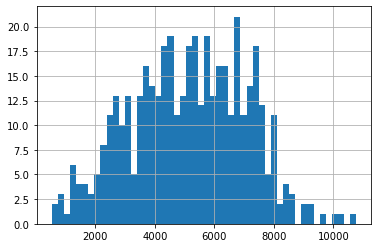

In [18]:
foot['time'].hist(bins=50)

In [19]:
# Make DataFrame lighter
cols = ['length'] + [col for col in foot.columns if col[-4:]=='time']
foot[cols] = foot[cols].astype(int)

In [20]:
# Add to LoS table
sm.pt_los = sm.pt_los.append(foot).reset_index(drop=True)

In [21]:
sm.pt_los.loc[sm.pt_los['route_type']=='walk'].sample()

,access_time,accessibility,destination,footpath_time,in_vehicle_time,length,link_path,ntransfers,origin,path,price,route_type,route_types,time,waiting_time
432897,0,1.0,DE401,5433,0,25658,[],0,DE40E,"(DE40E, foot_9829, DE401)",0.0,walk,"(walk,)",5433,0


## Save

In [22]:
sm.to_json(model_path + 'de_pt_los',
           only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 34/34 [00:06<00:00,  5.40it/s]
